# T6 - Calibration

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/starsimhub/starsim/blob/main/docs/tutorials/tut_calibration.ipynb?install=starsim) or [Binder](https://mybinder.org/v2/gh/starsimhub/starsim/HEAD?labpath=docs%2Ftutorials%2Ftut_calibration.ipynb).
    
</div>

Disease models typically require contextualization to a relevant setting of interest prior to addressing "what-if" scenario questions. The process of tuning model input parameters so that model outputs match observed data is known as calibration. There are many approaches to model calibration, ranging from manual tuning to fully Bayesian methods.

For many applications, we have found that an optimization-based approach is sufficient. Such methods avoid the tedious process of manual tuning and are less computationally expensive than fully Bayesian methods. One such optimization-based approach is the Optuna library, which is a Bayesian hyperparameter optimization framework. Optuna is designed for tuning hyperparameters of machine learning models, but it can also be used to calibrate disease models.

Calibration libraries often treat the disease model as a black box, where the input parameters are the "hyperparameters" to be tuned. The calibration process is often iterative and requires a combination of expert knowledge and computational tools. The optimization algorithm iteratively chooses new parameter values to evaluate, and the model is run with these values to generate outputs. The outputs are compared to observed data, and a loss function is calculated to quantify the difference between the model outputs and the observed data. The optimization algorithm then uses this loss function to update its search strategy and choose new parameter values to evaluate. This process continues until the algorithm converges to a set of parameter values that minimize the loss function.

While many optimization algorithms are available, Starsim has a built-in interface to the Optuna library, which we will demonstrate in this tutorial. We will use a simple Susceptible-Infected-Recovered (SIR) model as an example. We will tune three input parameters, the infectivity parameter, `beta`, the initial prevalence parameter, `init_prev`, and the Poisson-distributed degree distribution parameter, `n_contacts`. We will calibrate the model using a beta-binomial likelihood function so as to match prevalence at three distinct time points.

We begin with a few imports and default settings

In [1]:
#%% Imports and settings
import sciris as sc
import starsim as ss
import pandas as pd

n_agents = 2e3
debug = False # If true, will run in serial

/Users/dklein/miniforge3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The calibration class will require a base `Sim` object. This `sim` will later be modified according to parameters selected by the optimization engine. The following function creates the base `Sim` object.

In [2]:
def make_sim():
    """ Helper function to create the base simulation object """
    sir = ss.SIR(
        beta = ss.beta(0.075),
        init_prev = ss.bernoulli(0.02),
    )
    random = ss.RandomNet(n_contacts=ss.poisson(4))

    sim = ss.Sim(
        n_agents = n_agents,
        start = sc.date('1990-01-01'),
        dur = 40,
        dt = 1,
        unit = 'day',
        diseases = sir,
        networks = random,
        verbose = 0,
    )

    # Remember to return the sim object
    return sim

Now let's define the calibration parameters. These are the inputs that Optuna will be able to modify. Here, we define three such parameters, `beta`, `init_prev`, and `n_contacts`.

Each parameter entry should have range defined by `low` and `high` as well as a `guess` values. The `guess` value is not used by Optuna, rather only for a check after calibration completes to see if the new parameters are better than the `guess` values.

You'll notice there are a few other parameters that can be specified. For example, the data type of the parameter appears in `suggest_type`. Possible values are listed in the Optuna documentation, and include suggest_float (https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float) for float values and suggest_int (https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) for integer types.

To make things easier for the search algorithm, it's helpful to indicate how outputs are expected to change with inputs. For example, increasing `beta` from 0.01 to 0.02 should double disease transmission, but increasing from 0.11 to 0.12 will have a small effect. Thus, we indicate that this parameter should be calibrated with `log=True`.

In [3]:
# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True), # Note the log scale
    init_prev = dict(low=0.01, high=0.05, guess=0.15), # Default type is suggest_float, no need to re-specify
    n_contacts = dict(low=2, high=10, guess=3, suggest_type='suggest_int'), # Suggest int just for this demo
)

The optimization engine iteratively chooses input parameters to simulate. Those parameters are passed into the following `build_sim` function as a dictionary of `calib_pars` along with the base `sim` and any other key word arguments. The `calib_pars` will be as above, but importantly will have an additional key named `value` containing the value selected by Optuna.

When modifying a `sim`, it is important to realize that the simulation has not been initialized yet. Nonetheless, the configuration is available for modification at `sim.pars`, as demonstrated in the function below for the SIR example.

In [4]:
def build_sim(sim, calib_pars, **kwargs):
    """ Modify the base simulation by applying calib_pars """

    sir = sim.pars.diseases # There is only one disease in this simulation and it is a SIR
    net = sim.pars.networks # There is only one network in this simulation and it is a RandomNet

    for k, pars in calib_pars.items(): # Loop over the calibration parameters
        if k == 'rand_seed':
            sim.pars.rand_seed = v
            continue

        # Each item in calib_pars is a dictionary with keys like 'low', 'high',
        # 'guess', 'suggest_type', and importantly 'value'. The 'value' key is
        # the one we want to use as that's the one selected by the algorithm
        v = pars['value']
        if k == 'beta':
            sir.pars.beta = ss.beta(v)
        elif k == 'init_prev':
            sir.pars.init_prev = ss.bernoulli(v)
        elif k == 'n_contacts':
            net.pars.n_contacts = ss.poisson(v)
        else:
            raise NotImplementedError(f'Parameter {k} not recognized')

    return sim

Recall that an optimization-based approach to calibration minimizes a function of the input parameters. We compose the goodness-of-fit function using "components." Each component has real data, for example from a survey, that is compared against simulation data from the model. Several components and be used at the same time. Each computes a likelihood of the data given the input parameters, as assess via simulation. Components are assumed to be independent.

When defining a `CalibComponent`, we give it a `name` and pass in `real_data`. The required data fields depend on the likelihood function. Importantly, the functional form of the negative log likelihood, or nll, is defined by the `nll_fn`. The value for `nll_fn` can be any value of the eLikelihood enumeration, like `BETA_BINOMIAL`, or a negative log likelihood function of your creation. If designing your own function for `nll_fn`, it should take two arguments: `real_data` and `sim_data`. For a Beta binomial, the data must define `n` and `x`, where `n` is the number of individuals that were sampled and `x` is the number that were found, e.g. identified as positive.

Output from the simulation is obtained via a function. The function takes a completed `sim` object as input and returns a dictionary with fields as required for the `nll_fn` function. In the example below, we use an in-line lambda function. Like the `real_data`, the `sim_data_fn` for a Beta binomial requires `n` and `x`.

Each component has a `weight`. The final goodness of fit is a weighted sum of negative log likelihoods.

Finally, the `conform` argument describes how the simulation output is adjusted to align with the real data. For example, if the real data is a prevalence measurement, choosing `ss.eConform.PREVALENT` will interpolate the simulation output at the time points of the real data. Choosing `ss.eConform.INCIDENT`, the simulation output will be aggregated between time points of the real data.

In [5]:
infectious = ss.CalibComponent(
    name = 'Infectious',

    # "real_data" actually from a simulation with pars
    #   beta=0.075, init_prev=0.02, n_contacts=4
    real_data = pd.DataFrame({
        'n': [200, 197, 195], # Number of individuals sampled
        'x': [30, 30, 10],    # Number of individuals found to be infectious
    }, index=pd.Index([ss.date(d) for d in ['1990-01-12', '1990-01-25', '1990-02-02']], name='t')), # On these dates
    
    sim_data_fn = lambda sim: pd.DataFrame({
        'n': sim.results.n_alive,
        'x': sim.results.sir.n_infected,
    }, index=pd.Index(sim.results.timevec, name='t')),

    conform = ss.eConform.PREVALENT,
    nll_fn = ss.eLikelihood.BETA_BINOMIAL,

    weight = 1,
)

Finally, we can bring all the pieces together. We make a single base simulation and create an instance of a Starsim Calibration object. This object requires a few arguments, like the `calib_pars` and `sim`. We also pass in the function that modifies the base `sim`, here our `build_sim` function. No additional `build_kwargs` are required in this example.

We also pass in a list of `components`. Instead of using this "component-based" system, a user could simply provide an `eval_fn`, which takes in a completed sim an any `eval_kwargs` and returns a "goodness of fit" score to be maximized.

We can also specify the total number of trial to run, the number of parallel works, and a few other parameters.

In [6]:
sc.heading('Beginning calibration')

# Make the sim and data
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,

    build_fn = build_sim, # Use default builder, Calibration.translate_pars
    build_kwargs = None,

    components = [infectious],

    total_trials = 100,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug,
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate(confirm_fit=False);



—————————————————————
Beginning calibration
—————————————————————


Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db


[I 2024-11-16 21:37:43,528] A new study created in RDB with name: starsim_calibration
[I 2024-11-16 21:37:43,863] Trial 2 finished with value: 107.30873053298149 and parameters: {'beta': 0.287649229557548, 'init_prev': 0.01459633116681542, 'n_contacts': 8, 'rand_seed': 786992}. Best is trial 2 with value: 107.30873053298149.
[I 2024-11-16 21:37:43,903] Trial 1 finished with value: 141.71274040920855 and parameters: {'beta': 0.016131876512529307, 'init_prev': 0.03095733037020489, 'n_contacts': 6, 'rand_seed': 576498}. Best is trial 2 with value: 107.30873053298149.
[I 2024-11-16 21:37:43,905] Trial 7 finished with value: 115.95181064486735 and parameters: {'beta': 0.012305576988698542, 'init_prev': 0.03462649160173581, 'n_contacts': 9, 'rand_seed': 150095}. Best is trial 2 with value: 107.30873053298149.
[I 2024-11-16 21:37:43,937] Trial 5 finished with value: 85.2177244223318 and parameters: {'beta': 0.04392452421102194, 'init_prev': 0.03539336109748194, 'n_contacts': 3, 'rand_seed': 8

Making results structure...
Processed 112 trials; 0 failed
Best pars: {'beta': 0.036336486559483704, 'init_prev': 0.03628739942352108, 'n_contacts': 8, 'rand_seed': 599372}
Removed existing calibration file starsim_calibration.db


Let's look at the best parameters that were found. Note that the `rand_seed` was selected at random, but the other parameters are meaningful.

In [7]:
calib.best_pars

{'beta': 0.036336486559483704,
 'init_prev': 0.03628739942352108,
 'n_contacts': 8,
 'rand_seed': 599372}

Once the calibration is complete, we can compare the `guess` values to the best values found.


Confirming fit...

Confirming fit...
Elapsed time: 0.534 s
Elapsed time: 0.549 s
Fit with original pars: [102.88081432 103.17668444 101.76293553 101.73024849 101.42137967
 101.11678233 107.0659899  101.23460891  97.16017623  93.18140814
  96.57275981 104.53172647 100.64051879  97.88797276  98.78717759
  98.17993622  99.27916165 100.44520885  96.67673033 107.43027621
  89.47519502  82.59693358 105.32194039  98.86668559  95.6485363 ]
Fit with best-fit pars: [21.28778526  9.87210691 13.04061953  8.54594516 17.0739946  13.30003328
 13.85241925  8.66942731  8.90524631  7.94490608 11.10528388 10.93048302
  8.9045451  15.02814999 27.54693223 11.2977381  13.8170572   9.09956846
 11.8616321  11.43284868  8.37589914  7.48790625 24.09745799 16.4165328
 19.73485543]
✓ Calibration improved fit
Figure(933.333x700)


/Users/dklein/GIT/starsim/starsim/results.py:226: RuntimeWarning: 
You are adding a result from module randomnet to module MultiSim; check that this is intentional.
  ss.warn(warnmsg)
/Users/dklein/GIT/starsim/starsim/results.py:226: RuntimeWarning: 
You are adding a result from module sir to module MultiSim; check that this is intentional.
  ss.warn(warnmsg)
/Users/dklein/GIT/starsim/starsim/results.py:226: RuntimeWarning: 
You are adding a result from module sim to module MultiSim; check that this is intentional.
  ss.warn(warnmsg)


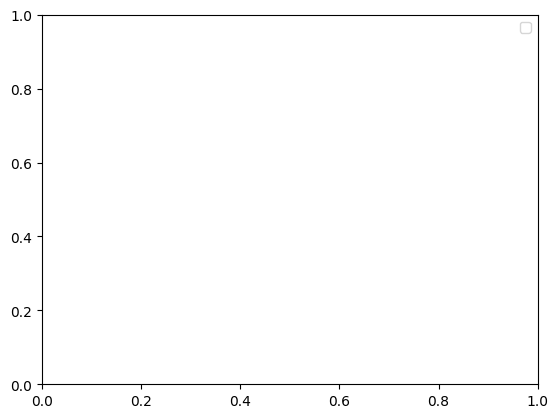

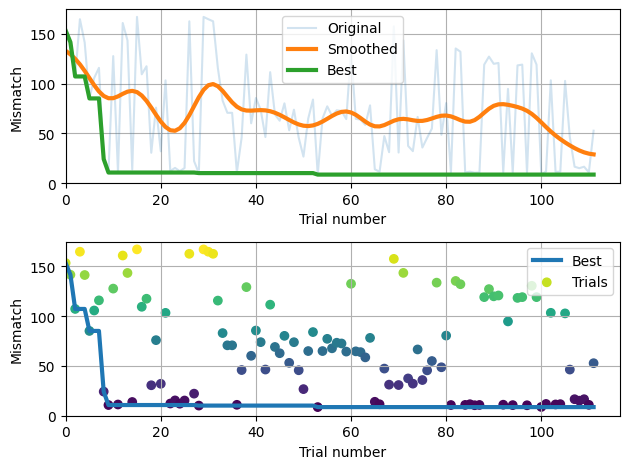

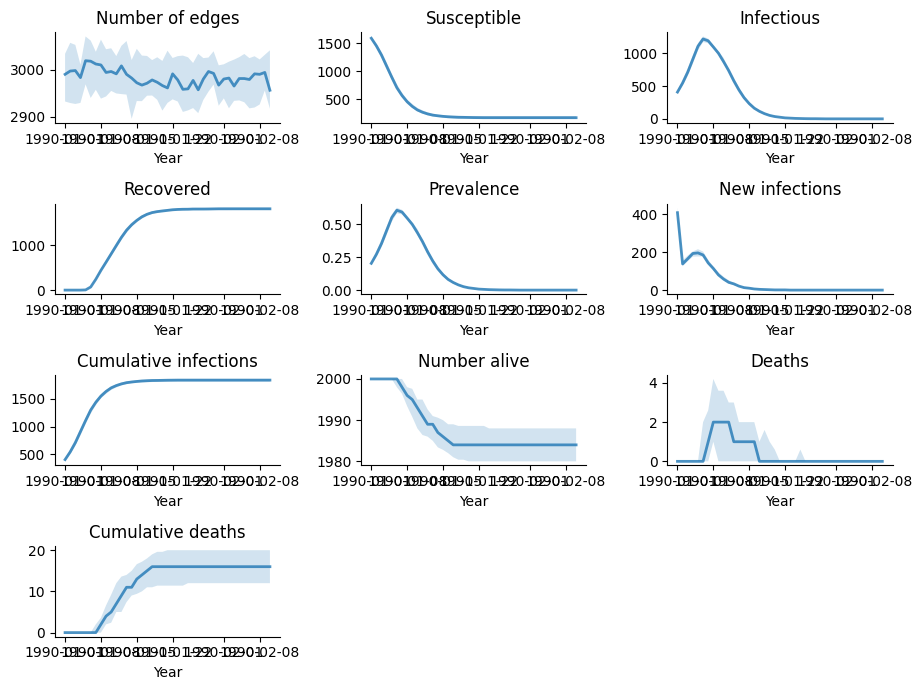

/Users/dklein/GIT/starsim/starsim/results.py:226: RuntimeWarning: 
You are adding a result from module randomnet to module MultiSim; check that this is intentional.
  ss.warn(warnmsg)
/Users/dklein/GIT/starsim/starsim/results.py:226: RuntimeWarning: 
You are adding a result from module sir to module MultiSim; check that this is intentional.
  ss.warn(warnmsg)
/Users/dklein/GIT/starsim/starsim/results.py:226: RuntimeWarning: 
You are adding a result from module sim to module MultiSim; check that this is intentional.
  ss.warn(warnmsg)


Figure(933.333x700)


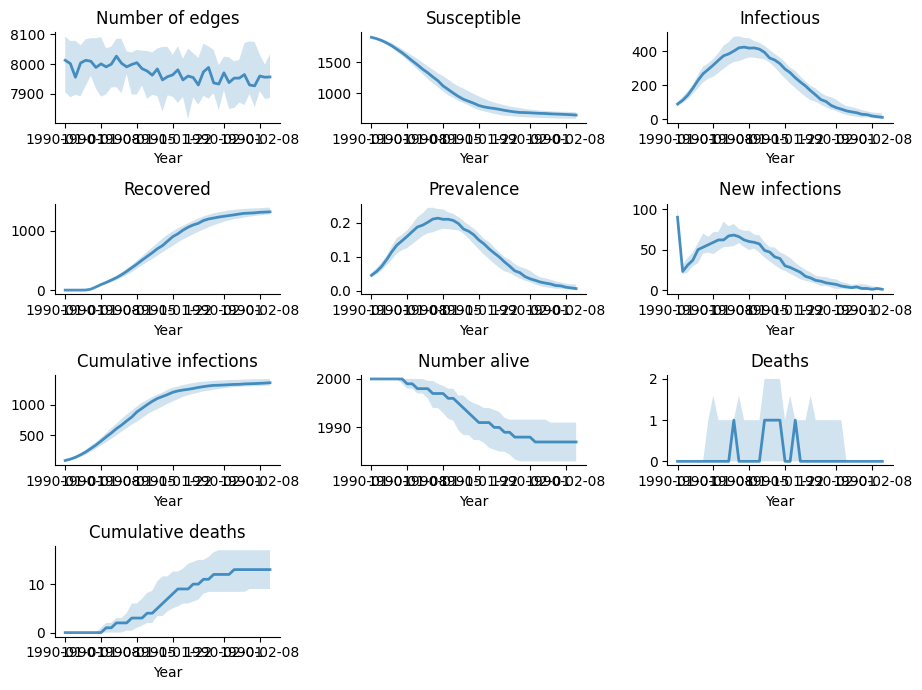

/Users/dklein/GIT/starsim/starsim/calibration.py:409: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


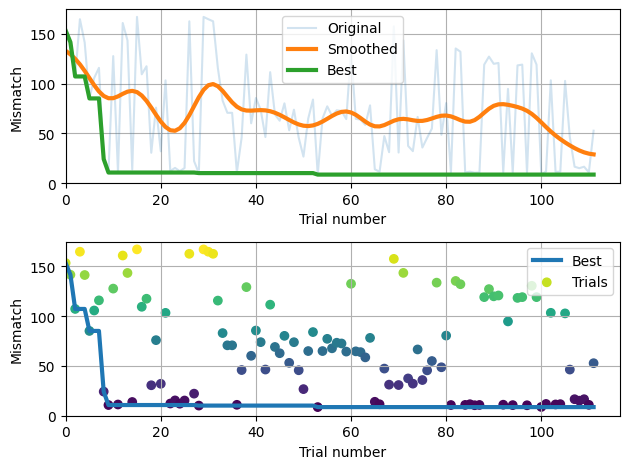

In [10]:
# Confirm
sc.printcyan('\nConfirming fit...')
calib.confirm_fit()

calib.plot_sims()
calib.plot_trend()